In [1]:
import urllib, urllib.request, xmltodict, feedparser
from datetime import datetime
from time import mktime
import pprint
from torch.utils.data import DataLoader, TensorDataset

import torch

In [2]:
import pandas as pd

In [3]:
def get_title_abs_arxiv(url):
    if 'arxiv' not in url: return -1,{}
    if 'pdf' in url: arxiv_id=''.join(url.split('pdf')[-2:-1])[1:-1]
    else: arxiv_id=url.split('/')[-1]
    query_url='http://export.arxiv.org/api/query?id_list='+arxiv_id
    data_dict = xmltodict.parse(urllib.request.urlopen(query_url).read())['feed']
    return 0,{'title':data_dict['entry']['title'],'abstract':' '.join(data_dict['entry']['summary'].split('\n'))}

In [4]:
def fetch_daily_arxiv_papers(cat='cs.LG'):
    feedurl=f'https://rss.arxiv.org/rss/{cat}'
    feed=feedparser.parse(feedurl)
    datestr=datetime.fromtimestamp(mktime(feed['feed']['published_parsed'])).strftime('%d-%b-%Y')
    daily_papers=[]
    for e in feed['entries']:
        paper_entry={'id':e['id'],'title':e['title'],
                     'abstract':' '.join(e['summary'].split('\n')),
                     'date':datestr}
        daily_papers.append(paper_entry)
    return daily_papers

In [5]:
train_urls = pd.read_csv('papers_of_interest.csv')

In [6]:
train_urls

,no,url
0,1,https://arxiv.org/pdf/2209.11142.pdf
1,2,https://arxiv.org/pdf/2212.02475.pdf
2,3,https://arxiv.org/pdf/2211.16564.pdf
3,4,https://arxiv.org/abs/1803.05316
4,5,https://arxiv.org/abs/2206.08896
...,...,...
308,309,https://arxiv.org/pdf/2401.03006.pdf
309,310,https://arxiv.org/pdf/2403.04732.pdf
310,311,https://arxiv.org/pdf/2404.08819.pdf
311,312,https://arxiv.org/pdf/2404.11483v1.pdf


In [7]:
# train_content = []
# for url in train_urls['url']:
#     status, content = get_title_abs_arxiv(url)
#     # print(content)
#     # break
#     if status == 0:
#         train_content.append(content)
#     else:
#         print(f"Failed to fetch content for {url}")

In [8]:
# convert train_content to a pandas dataframe
df = pd.read_csv('train_content.csv')

In [9]:
# df.to_csv('train_content.csv', index=False)

In [10]:
from transformers import *

tokenizer = AutoTokenizer.from_pretrained('allenai/specter2_base')
model = AutoModel.from_pretrained('allenai/specter2_base')


c:\Python311\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
c:\Python311\Lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
c:\Python311\Lib\site-packages\transformers\deepspeed.py:23: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(
c:\Python311\Lib\site-packages\transformers\generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warni

In [11]:
from datasets import Dataset

dataset = Dataset.from_pandas(df)

In [12]:
model.cuda()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(31090, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [13]:
dataset

Dataset({
    features: ['title', 'abstract'],
    num_rows: 313
})

In [14]:
len(dataset[0]['title'].split())

5

In [15]:
len((tokenizer(dataset['title'][0]))['input_ids'])


8

In [16]:
embeddings=[]

for i in range(len(dataset)):
    input_string = dataset['title'][i] + ' ' + dataset['abstract'][i]
    tokenized_input = tokenizer(input_string, return_tensors='pt', max_length=512, truncation=True, padding='max_length')
    tokenized_input = {k: v.cuda() for k, v in tokenized_input.items()}
    with torch.no_grad():
        outputs = model(**tokenized_input)
        last_hidden_states = outputs.last_hidden_state
        pooled_output = outputs.pooler_output
        # embedding = outputs.last_hidden_state[:,1,-1,:].squeeze(0)
        # print(last_hidden_states.shape)
        # print(pooled_output.shape)
        embeddings.append(pooled_output.cpu())
        # print(pooled_output)
        # print(embedding.shape)
        # break

In [17]:
import torch

# Stack the tensors along a new dimension
stacked_embeddings = torch.stack(embeddings)

# Compute the mean along that dimension
mean_embeddings = torch.mean(stacked_embeddings, dim=0)

In [18]:
unlabelled_data = pd.read_csv('daily_arxiv_papers.csv') 
# remove the rows with id , title , abstract, date as a row

ids = []
for i in range(len(unlabelled_data)):
    if unlabelled_data['id'][i] == 'id':
        ids.append(i)


# remove the rows with id , title , abstract, date as a row
unlabelled_data = unlabelled_data.drop(ids)

# make the indices start from 0
unlabelled_data = unlabelled_data.reset_index(drop=True)

# remove arXiv:2403.19669v1 Announce Type: new  Abstract: from the abstract
abstracts = unlabelled_data['abstract']
abstracts

0       arXiv:2403.19669v1 Announce Type: new  Abstrac...
1       arXiv:2403.19717v1 Announce Type: new  Abstrac...
2       arXiv:2403.19721v1 Announce Type: new  Abstrac...
3       arXiv:2403.19792v1 Announce Type: new  Abstrac...
4       arXiv:2403.19800v1 Announce Type: new  Abstrac...
                              ...                        
1099    The advent of large language models (LLMs) has...
1100    In this paper, we analyze the impact of data f...
1101    Complex single-objective bounded problems are ...
1102    Given a causal graph representing the data-gen...
1103    In this paper, we present OmniSearchSage, a ve...
Name: abstract, Length: 1104, dtype: object

In [19]:
new_abstracts = []
for abstract in abstracts:
    abstract = abstract.split('Abstract: ')
    if len(abstract) > 1:
        abstract = abstract[1]
    else:
        abstract = abstract[0]
    new_abstracts.append(abstract)
# new_abstracts

In [20]:
# new abstracts is new absracts for unlabeled data
unlabelled_data['abstract'] = new_abstracts

In [21]:
unlabelled_data.drop_duplicates(subset=['title'], inplace=True)

In [22]:
unlabelled_data

,id,title,abstract,date
0,oai:arXiv.org:2403.19669v1,Analyzing the Roles of Language and Vision in ...,Does language help make sense of the visual wo...,01-Apr-2024
1,oai:arXiv.org:2403.19717v1,A Picture is Worth 500 Labels: A Case Study of...,Mobile apps have embraced user privacy by movi...,01-Apr-2024
2,oai:arXiv.org:2403.19721v1,Computationally and Memory-Efficient Robust Pr...,"In the current data-intensive era, big data ha...",01-Apr-2024
3,oai:arXiv.org:2403.19792v1,MAPL: Model Agnostic Peer-to-peer Learning,Effective collaboration among heterogeneous cl...,01-Apr-2024
4,oai:arXiv.org:2403.19800v1,Gegenbauer Graph Neural Networks for Time-vary...,Reconstructing time-varying graph signals (or ...,01-Apr-2024
...,...,...,...,...
981,http://arxiv.org/abs/2404.16283v1,Andes: Defining and Enhancing Quality-of-Exper...,The advent of large language models (LLMs) has...,2024-04-25
982,http://arxiv.org/abs/2404.16281v1,Timely Communications for Remote Inference,"In this paper, we analyze the impact of data f...",2024-04-25
983,http://arxiv.org/abs/2404.16280v1,An Efficient Reconstructed Differential Evolut...,Complex single-objective bounded problems are ...,2024-04-25
984,http://arxiv.org/abs/2404.16277v1,Causally Inspired Regularization Enables Domai...,Given a causal graph representing the data-gen...,2024-04-25


In [23]:
unlabelled_embeddings=[]
unlabelled_dataset = Dataset.from_pandas(unlabelled_data)

unlabelled_dataset

Dataset({
    features: ['id', 'title', 'abstract', 'date', '__index_level_0__'],
    num_rows: 836
})

In [24]:
for i in range(len(unlabelled_dataset)):
    input_string = unlabelled_dataset['title'][i] + ' ' + unlabelled_dataset['abstract'][i]
    tokenized_input = tokenizer(input_string, return_tensors='pt', max_length=512, truncation=True, padding='max_length')
    tokenized_input = {k: v.cuda() for k, v in tokenized_input.items()}
    with torch.no_grad():
        outputs = model(**tokenized_input)
        last_hidden_states = outputs.last_hidden_state
        pooled_output = outputs.pooler_output
        # embedding = outputs.last_hidden_state[:,1,-1,:].squeeze(0)
        # print(last_hidden_states.shape)
        # print(pooled_output.shape)
        unlabelled_embeddings.append(pooled_output.cpu())
        # print(pooled_output)
        # print(embedding.shape)
        # break

In [25]:
# compute euclidean distance between mean_embeddings and unlabelled_embeddings
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np

mean_embeddings = mean_embeddings.cpu().numpy()
stacked_unlabelled_embeddings = torch.stack(unlabelled_embeddings)
stacked_unlabelled_embeddings = stacked_unlabelled_embeddings.cpu().numpy()
print(mean_embeddings.shape)
print(stacked_unlabelled_embeddings.shape)
# mean_embeddings = mean_embeddings.squeeze(0)
stacked_unlabelled_embeddings = stacked_unlabelled_embeddings.squeeze(1)
distances = euclidean_distances(mean_embeddings.reshape(1,-1), stacked_unlabelled_embeddings)
distances = distances.reshape(-1)
distances



(1, 768)
(836, 1, 768)


array([4.567787 , 4.5405173, 5.0938754, 4.831873 , 5.1816335, 4.868515 ,
       5.4974885, 5.9082227, 4.2132583, 5.625834 , 5.6464567, 5.361004 ,
       3.844457 , 4.5100245, 4.0481462, 4.558012 , 4.713201 , 4.0647397,
       5.8034663, 4.9440107, 5.4197097, 4.325507 , 6.051324 , 4.6337714,
       4.786901 , 5.8218307, 5.487824 , 5.0715733, 4.4352064, 3.9957843,
       5.117768 , 5.985867 , 4.779816 , 5.999028 , 7.5814557, 3.792974 ,
       4.933277 , 4.278781 , 4.883603 , 5.008872 , 4.5388517, 4.632354 ,
       5.421606 , 5.5741987, 6.125299 , 4.2091293, 5.305968 , 4.4546947,
       4.94908  , 4.3075233, 3.5731041, 5.0370245, 5.049589 , 3.222282 ,
       4.1869593, 4.7607794, 4.989899 , 3.8067276, 4.810914 , 4.068364 ,
       3.8329496, 4.044307 , 4.72099  , 4.6360154, 3.4335656, 5.683633 ,
       4.822538 , 6.6259565, 5.9705915, 4.8541484, 5.262266 , 5.2582293,
       5.5405574, 5.64006  , 5.5847335, 5.984848 , 5.493729 , 4.848004 ,
       5.064016 , 4.989391 , 5.355492 , 4.824261 , 

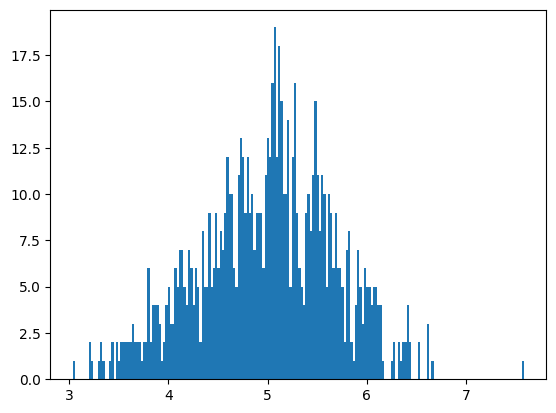

In [26]:
# histogram of distances
import matplotlib.pyplot as plt

plt.hist(distances, bins=200)
plt.show()


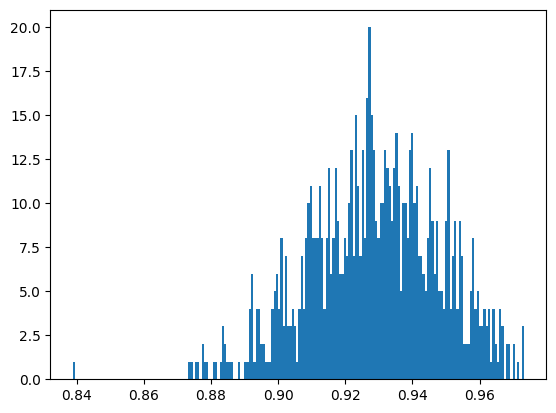

In [27]:
# compute cosine similarity between mean_embeddings and unlabelled_embeddings
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarities = cosine_similarity(mean_embeddings.reshape(1,-1), stacked_unlabelled_embeddings)
cosine_similarities = cosine_similarities.reshape(-1)
cosine_similarities

# histogram of cosine similarities
plt.hist(cosine_similarities, bins=200)
plt.show()


In [28]:
# create a neural network model to approximate g(x)
import torch.nn as nn
import torch.optim as optim

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(768, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 2)
        self.relu = nn.ReLU()
        # self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        # x = self.sigmoid(x)
        return x
# this model gives probability of the input being a labelled sample
# g_x_model = NeuralNetwork()
# g_x_model.cuda()

In [29]:
# # get indexes of all samples for 1st April 2024
# indexes = []
# for i in range(len(unlabelled_data)):
#     if unlabelled_data['date'].iloc[i] == '01-Apr-2024':
#         indexes.append(i)
# indexes

In [30]:
# first_april_embeddings = stacked_unlabelled_embeddings[indexes]

# # combine embeddings and first_april_embeddings into one dataset
# combined_embeddings = np.concatenate((stacked_embeddings.squeeze(1).cpu(), first_april_embeddings), axis=0)
# combined_embeddings.shape

# # create labels for the combined embeddings
# labels = np.zeros(combined_embeddings.shape[0])
# labels[:len(embeddings)] = 1
# len(labels)


In [31]:
# from torch.utils.data import DataLoader, TensorDataset

# combined_dataset = TensorDataset(torch.tensor(combined_embeddings), torch.tensor(labels))
# combined_dataloader = DataLoader(combined_dataset, batch_size=1, shuffle=False)


In [32]:

# # train the model
# criterion = nn.BCELoss()
# optimizer = optim.Adam(g_x_model.parameters(), lr=0.001)
# # model = NeuralNetwork()
# # model.cuda()
# num_epochs = 100
# for epoch in range(num_epochs):
#     epoch_loss = 0
#     for i, data in enumerate(combined_dataloader):
#         inputs, labels = data
#         inputs = inputs.cuda()
#         labels = labels.float().cuda()
#         optimizer.zero_grad()
#         outputs = g_x_model(inputs)
#         # print(labels)
#         # print(outputs)
#         loss = criterion(outputs, labels.unsqueeze(1))
#         loss.backward()
#         optimizer.step()
#         epoch_loss += loss.item()
#     print(f'Epoch: {epoch}, Loss: {epoch_loss}')
#         # print(f'Epoch: {epoch}, Batch: {i}, Loss: {loss.item()}')

In [33]:
# # have g(x) estimator trained

# # get 1-40 and last 30 samples from the combined embeddings
# # combined_embeddings.shape
# # combined_embeddings[0:40].shape
# # combined_embeddings[-30:].shape

# validation_set = np.concatenate((combined_embeddings[0:len(stacked_embeddings)], combined_embeddings[-60:]), axis=0)
# validation_labels = np.zeros(validation_set.shape[0])
# validation_labels[:100] = 1
# print(validation_set.shape)
# print(validation_labels.shape)


In [34]:
# set=validation_set[0:len(stacked_embeddings)].shape
# set_tensor = torch.tensor(validation_set[0:len(stacked_embeddings)])
# set_tensor = set_tensor.cuda()


In [35]:
# # validation_set is the V here , P is the first 40 samples

# const_prob = g_x_model(set_tensor)
# const_prob = const_prob.cpu().detach().numpy()
# const_prob = const_prob.reshape(-1)
# const_prob = const_prob.mean()
# const_prob #c

In [36]:
# w_x_samples = []
# for i in range(len(first_april_embeddings)):
#     p_s_x = g_x_model(torch.tensor(first_april_embeddings[i]).cuda())
#     p_s_x = p_s_x.cpu().detach().numpy()
#     # print(p_s_x)    
#     # print(p_s_x)
    
#     print(1-const_prob,const_prob,p_s_x,1-p_s_x)
#     w_x = ((1-const_prob)/const_prob)*(p_s_x[0]/(1-p_s_x[0]))
#     # print(w_x)
#     w_x_samples.append(w_x)
# w_x_samples

In [37]:
# w_x_samples = np.array(w_x_samples)

In [38]:
# w_x_samples.shape

In [39]:
# len(w_x_samples)

In [40]:
# create a new model that will now predict the labels
class NewModel(nn.Module):
    def __init__(self):
        super(NewModel, self).__init__()
        self.fc1 = nn.Linear(768, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 2)
        self.relu = nn.ReLU()
        # self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        # x = self.sigmoid(x)
        return x


In [41]:
# actual_model = NewModel()
# actual_model.cuda()

# criterion = nn.BCELoss()
# optimizer = optim.Adam(actual_model.parameters(), lr=0.01)
# num_epochs = 100


In [42]:
# first_april_embeddings = stacked_unlabelled_embeddings[indexes]
# first_april_positive = first_april_embeddings
# first_april_negative = first_april_embeddings   

In [43]:
# first_april_positive.shape, first_april_negative.shape,stacked_embeddings.squeeze(1).cpu().shape

In [44]:
# complete_training_set = np.concatenate((stacked_embeddings.squeeze(1).cpu(),first_april_positive, first_april_negative), axis=0)
# complete_training_set.shape

In [45]:
# complete_training_labels = np.zeros(complete_training_set.shape[0])
# complete_training_labels[:len(stacked_embeddings)] = 1
# complete_training_labels[len(stacked_embeddings):(len(stacked_embeddings)+first_april_positive.shape[0])] = 1
# complete_training_labels.shape

In [46]:
# complete_training_dataset = TensorDataset(torch.tensor(complete_training_set), torch.tensor(complete_training_labels))
# complete_training_dataloader = DataLoader(complete_training_dataset, batch_size=1, shuffle=False)

# for epoch in range(num_epochs):
#     epoch_loss = 0
#     for i, data in enumerate(complete_training_dataloader):
#         inputs, labels = data
#         inputs = inputs.cuda()
#         labels = labels.float().cuda()
#         # inputs = 
#         optimizer.zero_grad()
#         outputs = actual_model(inputs)
#         # print(labels)
#         # print(outputs)
#         # print(i)
#         if i < len(stacked_embeddings):
#             loss = criterion(outputs, labels.unsqueeze(1))
#             loss.backward()
#             optimizer.step()
#             epoch_loss += loss.item()

#         elif len(stacked_embeddings)< i < len(stacked_embeddings) + first_april_positive.shape[0]:
#             loss = criterion(outputs, labels.unsqueeze(1))*w_x_samples[i-len(stacked_embeddings)]
#             loss.backward()
#             optimizer.step()
#             epoch_loss += loss.item()

#         else:
#             loss = criterion(outputs, labels.unsqueeze(1))*(1-w_x_samples[i-len(stacked_embeddings)-first_april_positive.shape[0]])
#             loss.backward()
#             optimizer.step()
#             epoch_loss += loss.item()

#         # loss = criterion(outputs, labels.unsqueeze(1))* w_x_samples[i]
#     print(f'Epoch: {epoch}, Loss: {epoch_loss}')
#     # print(f'Epoch: {epoch}, Batch: {i}, Loss: {loss.item()}')
    

In [47]:
# # predict on unlabelled data
# predicted_labels = []
# for i in range(len(first_april_embeddings)):
#     p_s_x = actual_model(torch.tensor(first_april_embeddings[i]).cuda())
#     p_s_x = p_s_x.cpu().detach().numpy()
#     predicted_labels.append(p_s_x)

In [48]:
# predicted_labels

In [49]:
# predicted_labels
# # print values >0.5 as 1 and <0.5 as 0
# predicted_labels = np.array(predicted_labels)
# predicted_labels = predicted_labels>0.5
# predicted_labels = predicted_labels.astype(int)
# predicted_labels


# # print value counts of the predicted labels
# unique, counts = np.unique(predicted_labels, return_counts=True)
# dict(zip(unique, counts))


In [50]:
# create CrossEntropyLoss class 
class CrossEntropyLossCustom(nn.Module):
    def __init__(self):
        super(CrossEntropyLossCustom, self).__init__()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x, y, w_x):
        x = self.softmax(x)
        loss = -torch.mean(w_x*(y*torch.log(x)))
        return loss


In [98]:
def pipeline(date):
    g_x_model = NeuralNetwork()
    g_x_model.cuda()
    indexes = []
    for i in range(len(unlabelled_data)):
        # if unlabelled_data['date'].iloc[i] == date:
        indexes.append(i)
    first_april_embeddings = stacked_unlabelled_embeddings[indexes]
    print(first_april_embeddings.shape,"fe shape")
    combined_embeddings = np.concatenate((stacked_embeddings.squeeze(1).cpu(), first_april_embeddings), axis=0)
    labels = np.zeros(combined_embeddings.shape[0])
    labels[:len(embeddings)] = 1
    combined_dataset = TensorDataset(torch.tensor(combined_embeddings), torch.tensor(labels))
    combined_dataloader = DataLoader(combined_dataset, batch_size=1, shuffle=False)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(g_x_model.parameters(), lr=0.00001)
    # print(combined_embeddings,"gesgwsg")
    num_epochs = 75
    for epoch in range(num_epochs):
        epoch_loss = 0
        for i, data in enumerate(combined_dataloader):
            inputs, labels = data
            inputs = inputs.cuda()
            labels = labels.long().cuda()
            optimizer.zero_grad()
            outputs = g_x_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f'Epoch: {epoch}, Loss: {epoch_loss}')
    const_prob = torch.softmax(g_x_model(torch.tensor(combined_embeddings[0:(len(stacked_embeddings)-50)]).cuda()),dim=1)
    # print(const_prob[0])
    # get all values at the 1st index of the tensor
    const_prob = const_prob[:,1]
    print(const_prob.shape,"lgyog")
    # print(const_prob.shape,"lgyog")
    const_prob = const_prob.cpu().detach().numpy()
    const_prob = const_prob.reshape(-1)
    const_prob = const_prob.mean()
    print(const_prob,"vcdsg")
    w_x_samples = []

    for i in range(len(first_april_embeddings)):
        p_s_x = g_x_model(torch.tensor(first_april_embeddings[i]).cuda())
        probs = torch.softmax(p_s_x, dim=0)
        probs = probs.cpu().detach().numpy()
        # print(probs,"sgsg")

        # p_s_x = p_s_x.cpu().detach().numpy()
        # break
        w_x = ((1-const_prob)/const_prob)*(probs[1]/(1-probs[1]))
        w_x_samples.append(w_x)
    w_x_samples = np.array(w_x_samples)
    # print("wgsg",w_x_samples)
    # normalize w_x_samples
    w_x_samples = w_x_samples/w_x_samples.mean()
    actual_model = NewModel()
    actual_model.cuda()
    criterion = nn.CrossEntropyLoss()
    actual_optimizer = optim.Adam(actual_model.parameters(), lr=0.001)
    num_epochs = 50
    first_april_positive = first_april_embeddings
    first_april_negative = first_april_embeddings
    complete_training_set = np.concatenate((stacked_embeddings.squeeze(1).cpu(),first_april_positive, first_april_negative), axis=0)
    complete_training_labels = np.zeros(complete_training_set.shape[0])
    complete_training_labels[:len(stacked_embeddings)] = 1
    complete_training_labels[len(stacked_embeddings):(len(stacked_embeddings)+first_april_positive.shape[0])] = 1
    complete_training_dataset = TensorDataset(torch.tensor(complete_training_set), torch.tensor(complete_training_labels))

    complete_training_dataloader = DataLoader(complete_training_dataset, batch_size=1, shuffle=False)
    return complete_training_dataloader, w_x_samples, first_april_embeddings,first_april_positive,first_april_negative,stacked_embeddings

def predict(complete_training_dataloader, w_x_samples, first_april_embeddings,first_april_positive,first_april_negative,stacked_embeddings):
    actual_model = NewModel()
    actual_model.cuda()
    criterion = nn.CrossEntropyLoss()
    actual_optimizer = optim.Adam(actual_model.parameters(), lr=0.00001)
    num_epochs = 100

    for epoch in range(num_epochs):
        epoch_loss = 0
        for i, data in enumerate(complete_training_dataloader):
            
            wt= torch.tensor(0)
            wt = wt.cuda()
            if i < len(stacked_embeddings):
                wt = 1
            elif len(stacked_embeddings)< i < len(stacked_embeddings) + first_april_positive.shape[0]:
                wt=w_x_samples[i-len(stacked_embeddings)]
            else:
                wt=(1-w_x_samples[i-len(stacked_embeddings)-first_april_positive.shape[0]])
            # print(wt,i)
            inputs, labels = data
            inputs = inputs.cuda()
            labels = labels.long().cuda()
            actual_optimizer.zero_grad()
            outputs = actual_model(inputs)
            # print(outputs,labels)
            loss_actual = criterion(outputs, labels)*wt
            # print(loss_actual)
            loss_actual.backward()
            actual_optimizer.step()
            epoch_loss += loss_actual.item()
            
        print(f'Epoch: {epoch}, Loss: {epoch_loss/len(complete_training_dataloader)}')
    predicted_labels = []
    for i in range(len(first_april_embeddings)):
        p_s_x = actual_model(torch.tensor(first_april_embeddings[i]).cuda())
        # print(p_s_x)
        p_s_x = p_s_x.cpu().detach().numpy()
        predicted_labels.append(p_s_x)
    predicted_labels = np.array(predicted_labels)
    print("predicted labels",predicted_labels)
    return predicted_labels


In [99]:
complete_training_dataloader, w_x_samples, first_april_embeddings,first_april_positive,first_april_negative,stacked_embeddings = pipeline('12-Apr-2024')
predicted_labels = predict(complete_training_dataloader, w_x_samples, first_april_embeddings,first_april_positive,first_april_negative,stacked_embeddings)


(836, 768) fe shape
Epoch: 0, Loss: 388.5160922091454
Epoch: 1, Loss: 467.741330396384
Epoch: 2, Loss: 380.73664939776063
Epoch: 3, Loss: 330.1784589905292
Epoch: 4, Loss: 308.1205305522308
Epoch: 5, Loss: 273.5168316140771
Epoch: 6, Loss: 260.82890295097604
Epoch: 7, Loss: 240.51057925145142
Epoch: 8, Loss: 229.17780393362045
Epoch: 9, Loss: 220.40594868501648
Epoch: 10, Loss: 212.6123870149022
Epoch: 11, Loss: 206.7710744033102
Epoch: 12, Loss: 201.9012194161769
Epoch: 13, Loss: 195.45873518136796
Epoch: 14, Loss: 191.40295459510526
Epoch: 15, Loss: 187.8171668588766
Epoch: 16, Loss: 184.3489509546198
Epoch: 17, Loss: 181.57823231915245
Epoch: 18, Loss: 178.7521238301415
Epoch: 19, Loss: 176.48344383839867
Epoch: 20, Loss: 174.30780076954397
Epoch: 21, Loss: 172.40006967895897
Epoch: 22, Loss: 170.38379110442474
Epoch: 23, Loss: 168.6821566511353
Epoch: 24, Loss: 167.00510476375348
Epoch: 25, Loss: 165.32572316036385
Epoch: 26, Loss: 163.62038918136386
Epoch: 27, Loss: 162.0454154707

In [93]:
predicted_labels

array([[-35.72483   ,  41.007298  ],
       [  0.06531733,   5.063669  ],
       [ 19.629444  , -13.999677  ],
       ...,
       [ 23.090683  , -17.461338  ],
       [ -1.3720555 ,   6.6948295 ],
       [  4.8271365 ,   0.07027562]], dtype=float32)

In [94]:
# take argmax of the predicted labels
actual_labels = np.argmax(predicted_labels, axis=1)
actual_labels

array([1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1,

In [100]:
# get value counts of the actual labels
unique, counts = np.unique(actual_labels, return_counts=True)
dict(zip(unique, counts))


{0: 523, 1: 313}

In [96]:
# append actual labels to the unlabelled data
unlabelled_data['predicted_labels'] = actual_labels
unlabelled_data

,id,title,abstract,date,predicted_labels
0,oai:arXiv.org:2403.19669v1,Analyzing the Roles of Language and Vision in ...,Does language help make sense of the visual wo...,01-Apr-2024,1
1,oai:arXiv.org:2403.19717v1,A Picture is Worth 500 Labels: A Case Study of...,Mobile apps have embraced user privacy by movi...,01-Apr-2024,1
2,oai:arXiv.org:2403.19721v1,Computationally and Memory-Efficient Robust Pr...,"In the current data-intensive era, big data ha...",01-Apr-2024,0
3,oai:arXiv.org:2403.19792v1,MAPL: Model Agnostic Peer-to-peer Learning,Effective collaboration among heterogeneous cl...,01-Apr-2024,0
4,oai:arXiv.org:2403.19800v1,Gegenbauer Graph Neural Networks for Time-vary...,Reconstructing time-varying graph signals (or ...,01-Apr-2024,0
...,...,...,...,...,...
981,http://arxiv.org/abs/2404.16283v1,Andes: Defining and Enhancing Quality-of-Exper...,The advent of large language models (LLMs) has...,2024-04-25,0
982,http://arxiv.org/abs/2404.16281v1,Timely Communications for Remote Inference,"In this paper, we analyze the impact of data f...",2024-04-25,0
983,http://arxiv.org/abs/2404.16280v1,An Efficient Reconstructed Differential Evolut...,Complex single-objective bounded problems are ...,2024-04-25,0
984,http://arxiv.org/abs/2404.16277v1,Causally Inspired Regularization Enables Domai...,Given a causal graph representing the data-gen...,2024-04-25,1


In [97]:
# unlabelled_data.to_csv('saved_pred.csv', index=False)